# Area division and optimal alocation for complex areas
## Generate random AoI
 * simplify generation
 * generate obstacles and return single poly with hole
 * function that combines into single holed poly, so that inputs can be replaced with real inputs not random gen
 
### Generate desired coverage area

In [1]:
import random
import numpy as np
import math
from shapely.geometry import box, Polygon, MultiPolygon, GeometryCollection, Point

def pol2cart(rho, phi):
    phi=phi/180*math.pi
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(int(x), int(y))

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)/math.pi*180
    return(rho, phi)

def generate_random_polygon(number_of_corners, scale=300):
    corners = []
    for _ in range(number_of_corners):
        corners.append(tuple([random.randint(-scale,scale), random.randint(-scale,scale)]))

    xc = sum([pt[0] for pt in corners])/number_of_corners
    yc = sum([pt[1] for pt in corners])/number_of_corners

    polar_corners = []
    for pt in corners:
        polar_corners.append(cart2pol(pt[0]-xc, pt[1]- yc))

    sorted_polar_corners = sorted(polar_corners, key=lambda x: x[1])

    sorted_corners = []
    for pt in sorted_polar_corners:
        x, y = (pol2cart(pt[0],pt[1]))
        sorted_corners.append((x+xc,y+yc))
        
    return Polygon(sorted_corners), (xc, yc)

In [2]:
aoi, center = generate_random_polygon(8)

### Plotting Polygon objects

In [3]:
import matplotlib.pyplot as plt

def plot_poly(poly, fill_color=False):
    if isinstance(poly, (list,)):
        for p in poly:
            x, y = p.exterior.xy
            if fill_color:            
                plt.fill(x, y, edgecolor='black', facecolor=fill_color)
            else:
                plt.fill(x, y, edgecolor='black')
    else:
        x, y = poly.exterior.xy
        if fill_color:            
            plt.fill(x, y, edgecolor='black', facecolor=fill_color)
        else:
            plt.fill(x, y, edgecolor='black')

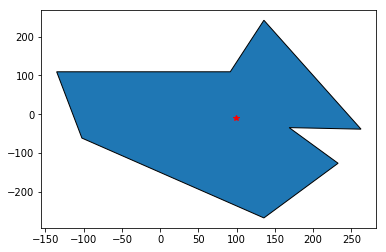

In [4]:
plot_poly(aoi)
plt.plot(center[0],center[1], 'r*')

### Generating obstacles / no fly zones

In [5]:
def generate_random_obstacles(number_of_obstacles, number_of_corners = 3, scale = 100):
    obstacles = []
    for _ in range(number_of_obstacles):
            obstacles.append(generate_random_polygon(number_of_corners, scale=scale)[0])
    return obstacles

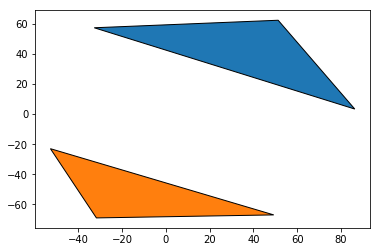

In [6]:
obstacles = generate_random_obstacles(2)
plot_poly(obstacles)

### Combined plot

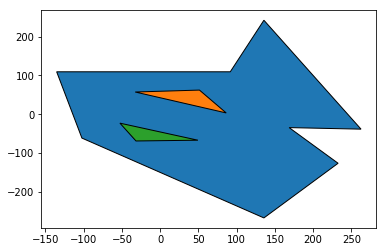

In [7]:
plot_poly(aoi)
plot_poly(obstacles)

## Generating simple shapes from left over area

In [8]:
def generate_tiles(aoi, obstacles):
    aoi_and_obstacles = Polygon(aoi)
    
    x_tilepoints = []
    for obs in obstacles:
        aoi_and_obstacles = aoi_and_obstacles.difference(obs)
        obs_points = set(list(obs.exterior.coords))
        for pt in obs_points:
            x_tilepoints.append(pt[0])
            
    aoi_points = set(list(aoi.exterior.coords))
    aoi_convex = aoi.convex_hull
    hull_points = set(list(aoi_convex.exterior.coords))
    to_add = [pt[0] for pt in list(aoi_points-hull_points)]
    x_tilepoints.extend(to_add)
    
    bounds = aoi.bounds
    x_tilepoints = sorted(set(x_tilepoints))
    x_tilepoints.append(bounds[2])
    
    tiles = []
    for i, x in enumerate(x_tilepoints):
        if i == 0:
            tile = box(bounds[0], bounds[1], x, bounds[3])
        else:
            tile = box(x_tilepoints[i - 1], bounds[1], x, bounds[3])
        tiled_poly = aoi_and_obstacles.intersection(tile)
        
        if isinstance(tiled_poly, (MultiPolygon, GeometryCollection)):
            tiled_poly = list(tiled_poly)
            tiles.extend([p for p in tiled_poly if isinstance(p, Polygon)])
        else:
            tiles.append(tiled_poly)
    return tiles

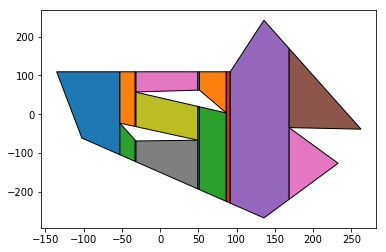

In [9]:
tiles = generate_tiles(aoi, obstacles)
plot_poly(tiles)

### Divide tiles above certain threshold

In [66]:
def divide_tile(tile):
    bounds = tile.bounds
    width = bounds[2] - bounds[0]
    height = bounds[3] - bounds[1]
    if height >= width:
        tile_top = box(bounds[0], bounds[1], bounds[2], bounds[1] + height / 2)
        tile_bottom = box(bounds[0], bounds[1] + height / 2, bounds[2], bounds[3])
        list_split_tile = [tile.intersection(tile_top), tile.intersection(tile_bottom)]
    else:
        tile_left = box(bounds[0], bounds[1], bounds[0] + width / 2, bounds[3])
        tile_right = box(bounds[0] + width / 2, bounds[1], bounds[2], bounds[3])
        list_split_tile = [tile.intersection(tile_left), tile.intersection(tile_right)]
    return list_split_tile

def reduce_large_tiles(tiles, threshold):
    new_tiles = []
    for tile in tiles:
        if tile.area <= threshold:
            new_tiles.append(tile)
        else:
            subtile_list = divide_tile(tile)
            new_tiles.extend(reduce_large_tiles(subtile_list, threshold))
    return [tile for tile in new_tiles if isinstance(tile, (Polygon, ))]

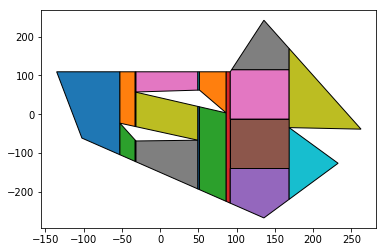

In [11]:
reduced_tiles = reduce_large_tiles(tiles, 15000)
plot_poly(reduced_tiles)

## Optimal allocation
### Parameter calculations and inputs

In [51]:
def calc_pts_in_common(tiles):
    pts_in_common = {}
    for i, tile in enumerate(tiles):
        pts_in_common[i] = {}
        tile_points_list = list(tile.exterior.coords)
        for j, tile_2 in enumerate(tiles):
            tile_points_list_2 = list(tile_2.exterior.coords)
            if i == j:
                pts_in_common[i][j] = 0
            else:
                pts_in_common[i][j] = sum([pt in tile_points_list for pt in tile_points_list_2])
    return pts_in_common

def calc_params(tiles):
    tile_areas = [tile.area for tile in tiles]
    pts_in_common = calc_pts_in_common(tiles)
    return tile_areas, pts_in_common
    
tile_areas, pts_in_common = calc_params(reduced_tiles)

asset_area_capacities = [30000, 40000, 50000, 60000]



### LP Model

In [47]:
import pulp as plp

def build_model(asset_area_capacities, tile_areas, pts_in_common, model_number=''):
    
    n_assets = len(asset_area_capacities)
    n_cells = len(tile_areas)
    
    opt_model = None
    opt_model = plp.LpProblem(name="Area Allocation"+model_number)

    # variables
    asset_used_variables = {(a): plp.LpVariable(cat=plp.LpBinary, name="asset_used_{0}".format(a))
                             for a in range(n_assets)}

    asset_cell_variables  = {(a,c,cc): plp.LpVariable(cat=plp.LpBinary, name="asset_cell_{0}_{1}_{2}".format(a,c,cc))
                             for a in range(n_assets) for c in range(n_cells) for cc in range(c, n_cells)}

    # constraints
    # capacity constraint on each asset  
    for a in range(n_assets):
        opt_model += plp.lpSum(asset_cell_variables[a,c,c]*tile_areas[c] for c in range(n_cells)) <= asset_area_capacities[a] , "asset_capacity_{0}".format(a)

    # each cell must be assigned once and only once
    for c in range(n_cells):
        opt_model += plp.lpSum(asset_cell_variables[a,c,c] for a in range(n_assets)) == 1 , "cell_assignment_tracking_{0}".format(c)

    # the variables tracking cells assigned together same asset must reflect the "diagonal" variables tracking cell assignment
    for a in range(n_assets):
        for c in range(n_cells):
            for cc in range(c, n_cells):
                opt_model += (asset_cell_variables[a,c,cc] >= asset_cell_variables[a,c,c] + asset_cell_variables[a,cc,cc] -1,
                "cell_combination_tracking_A{}_{}_{}".format(a,c,cc))

                opt_model += (asset_cell_variables[a,c,cc] <= (asset_cell_variables[a,c,c] + asset_cell_variables[a,cc,cc])/2,
                "cell_combination_tracking_B{}_{}_{}".format(a,c,cc))

    # track asset useage
    for a in range(n_assets):
        for c in range(n_cells):
            for cc in range(c, n_cells):
                opt_model += (asset_used_variables[a] >= asset_cell_variables[a,c,cc],
                "asset_useage_tracking_{0}_{1}_{2}".format(a,c,cc))            

    # objective = plp.lpSum(asset_used_variables[a] for a in range(n_assets))
    objective = plp.lpSum(-asset_cell_variables[a,c,cc]*pts_in_common[c][cc] for a in range(n_assets) for c in range(n_cells) for cc in range(c, n_cells))
    opt_model.sense = plp.LpMinimize
    opt_model.setObjective(objective)
    
    return opt_model


In [41]:
def solve_model(model):
    model.solve()
    print("Model {} status: {}".format(model.name, plp.LpStatus[model.status]))
    solution = {}
    for var in model.variables():
        solution[var.name] = var.value()
    return solution

In [ ]:
model = build_model(asset_area_capacities, tile_areas, pts_in_common)
solution = solve_model(model)

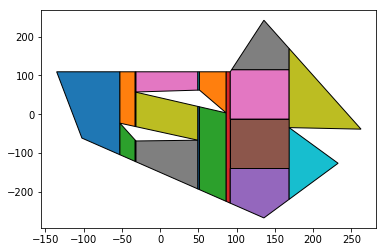

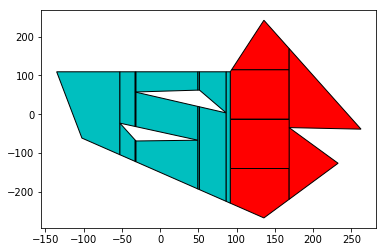

In [54]:
from matplotlib import colors as mcolors

def plot_solution(solution, n_assets, tiles):
    colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
    colors = list(colors.keys())
    for a in range(n_assets):
        for c in range(len(tiles)):
            if solution["asset_cell_{0}_{1}_{2}".format(a,c,c)] == 1:
                plot_poly(tiles[c], fill_color=colors[a])
    

plot_poly(reduced_tiles)
plt.figure()
plot_solution(solution, len(asset_area_capacities), reduced_tiles)

## Testing

Model Area Allocation0 status: Optimal
Model Area Allocation1 status: Optimal
Model Area Allocation2 status: Optimal


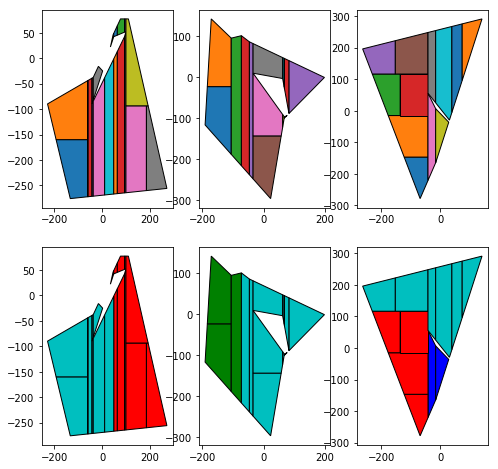

In [72]:
def test_algorithm(n_tests, asset_area_capacities):
    plt.figure(figsize=(8,8))
    for x in range(n_tests):
        number_of_corners_aoi = random.randint(4,8)
        aoi, center = generate_random_polygon(number_of_corners_aoi)
        
        number_of_obstacles = random.randint(1,2)
        number_of_corners_obstacles = random.randint(4,6)  
        obstacles = generate_random_obstacles(number_of_obstacles, number_of_corners_obstacles)
        
        tiles = generate_tiles(aoi, obstacles)
        reduced_tiles = reduce_large_tiles(tiles, 15000)
                
        tile_areas, pts_in_common = calc_params(reduced_tiles)
        
        model = build_model(asset_area_capacities, tile_areas, pts_in_common, model_number=str(x))
        
        solution = solve_model(model)
        
        plt.subplot(2, n_tests, 1 + x)
        plot_poly(reduced_tiles)
        plt.subplot(2, n_tests, 1 + n_tests+ x)
        plot_solution(solution, len(asset_area_capacities), reduced_tiles)
        

asset_area_capacities = [30000, 40000, 50000, 60000]
test_algorithm(3, asset_area_capacities)      
